In [5]:
from os import listdir
from os.path import isfile, join
import math
import torch

from models.imagenet_resnet import resnet18, resnet50
from models.cifar_resnet import resnet20, resnet32, resnet56
from torch import nn as nn 

from scipy.spatial.distance import cdist
import numpy as np

import gudhi as gd
from gudhi import wasserstein

import time

from scipy.spatial import distance
import numpy as np
from ripser import ripser
from persim import plot_diagrams
from gph.python import ripser_parallel
from scipy.spatial.distance import pdist, squareform
#import ripserplusplus as rpp_py
import time
import matplotlib.pyplot as plt

from sklearn import manifold 

In [5]:
class DigitNet(nn.Module):

    def __init__(self, num_classes=1000, **kwargs):
        super(DigitNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 5 * 5, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(x.size(0), -1))
        return x

In [4]:
net2 = DigitNet()

In [5]:
torch.min(net2.features[0].weight), torch.max(net2.features[0].weight)

(tensor(-0.1154, grad_fn=<MinBackward1>),
 tensor(0.1155, grad_fn=<MaxBackward1>))

In [6]:
np.linalg.norm([-10,10])

14.142135623730951

In [7]:
folder = "./lightning_logs/version_60/checkpoints/"

In [8]:
model.conv_1_3x3

NameError: name 'model' is not defined

In [9]:
model = resnet20(num_classes =10)
mask_index = [x for x in range(0, 57, 3)]


CifarResNet : Depth : 20 , Layers for each block : 3


In [23]:
def calculate_topo_stats(folder, model, mask_index):
    onlyfiles = np.array([f for f in listdir(folder) if isfile(join(folder, f))])

    stats_0d, stats_1d = {key:[] for key in mask_index}, {key:[] for key in mask_index}
    norms = {key:[] for key in mask_index}
    for epoch in range(170):
        #print(epoch)
        name = 'epoch='+str(epoch)+"-"
        file_name = onlyfiles[[name in i for i in onlyfiles]][0]
        file = torch.load(folder+file_name,
                         map_location=torch.device('cpu'))
        ckpt_dict = {'.'.join(k.split(".")[1:]): v for k, v in file["state_dict"].items()}
        model.load_state_dict(ckpt_dict)

        mask_index = [x for x in range(0, 57, 3)]

        for index, item in enumerate(model.parameters()):
            if index in mask_index[-1:]:
                layer_weight = item
                weight_vec = layer_weight.view(layer_weight.size()[0], -1).data
                weight_torch = layer_weight.data
                norm = np.linalg.norm(weight_vec, axis=1)
                non_empty_norm = norm[norm!=0]
                # print(layer_weight.shape)
                wass_dist = []
                """
                for channel in range(layer_weight.shape[1]):
                    vec= layer_weight[:,channel,:,:].data
                    vec = vec.reshape([layer_weight.shape[0], -1])
                    #print(vec.shape)
                    similar_matrix = cdist(vec, vec, 'euclidean')
                    topo_res = ripser_parallel(similar_matrix, metric="precomputed",
                               maxdim=1, n_threads=-1, return_generators=True)
                    bd_pairs = topo_res['dgms']
                    total_persistence = wasserstein.wasserstein_distance(bd_pairs[1], np.array([[0, 0]]), 
                                                 order=1, internal_p=1)
                    
                    wass_dist.append(total_persistence)
                """ 

                similar_matrix = cdist(weight_vec, weight_vec, 'euclidean')
                norms[index].append([np.mean(non_empty_norm),np.max(non_empty_norm),
                                     np.sum(np.linalg.norm(similar_matrix, axis=0))])
                #norms[index].append(np.sum(np.linalg.norm(similar_matrix, axis=0)))
                topo_res = ripser_parallel(similar_matrix, metric="precomputed",
                               maxdim=1, n_threads=-1, return_generators=True)
                bd_pairs = topo_res['dgms']
                generators = topo_res['gens']

                # 0-dim stats
                deaths = bd_pairs[0].T[1][:-1]

                if epoch%20 == 0:
                    print(epoch)
                    pair = np.array(bd_pairs[0][:-1])
                    #plt.plot(pair.T[0], pair.T[1], "o")
                    #plt.show()
                    mds_model = manifold.MDS(n_components = 2, random_state = 124,
                        dissimilarity = 'precomputed')
                    mds_fit = mds_model.fit(similar_matrix)
                    mds_coords = mds_model.fit_transform(similar_matrix) 
                    #plt.scatter(mds_coords[:,0],mds_coords[:,1])
                    #plt.show()
                    
                    fig, axes = plt.subplots(1,2, figsize=(10,4))
                    #axes[0].scatter(pair.T[0], pair.T[1])
                    # axes[0].scatter(bd_0.T[0],bd_0.T[1])
                    #axes[0].plot([0, 1], [0, 1])
                    #axes[0].set_xlim([-0.01, 0.17])
                    #axes[0].set_ylim([0.0, 0.17])
                    print(np.mean(deaths))
                    axes[1].scatter(mds_coords[:,0],mds_coords[:,1])
                    #plt.xlim([-1.6, 1.6])
                    #plt.ylim([-1.6, 1.6])
                    plt.show()
                    
                    
                #print(len(deaths),np.sum(deaths),np.mean(deaths), np.min(deaths ), np.max(deaths ))
                stats_0d[index].append([len(deaths),np.sum(deaths),np.mean(deaths),
                                        np.min(deaths ), np.max(deaths )])
                # 1st dim stats
                total_persistence = wasserstein.wasserstein_distance(bd_pairs[1], np.array([[0, 0]]), 
                                                 order=1, internal_p=1)
                n_1d_points = len(bd_pairs[1])
                #average_lifespan_1d = total_persistence/n_1d_points
                average_lifespan_1d=0
                #previous_bd = bd_pairs[1]
                #dist_to_prev = wasserstein.wasserstein_distance(bd_pairs[1], previous_bd, 
                #                                 order=1, internal_p=1)
                stats_1d[index].append([total_persistence, n_1d_points, 
                                        average_lifespan_1d, np.mean(wass_dist)])
                
                #print(total_persistence, n_1d_points, average_lifespan_1d, dist_to_prev)
        
    return stats_0d, stats_1d, norms

0
1.6283404


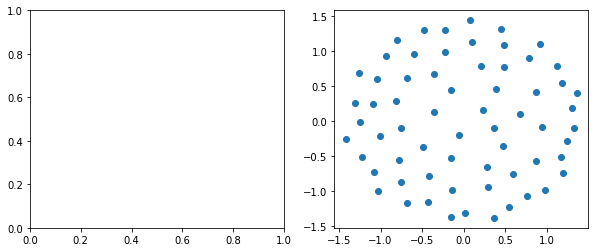

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20
0.5714462


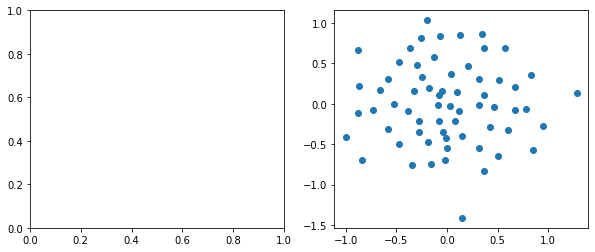

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40
0.5722683


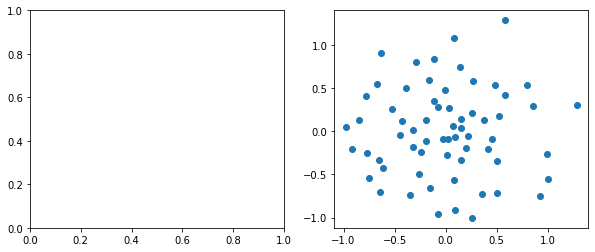

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


60
0.55381644


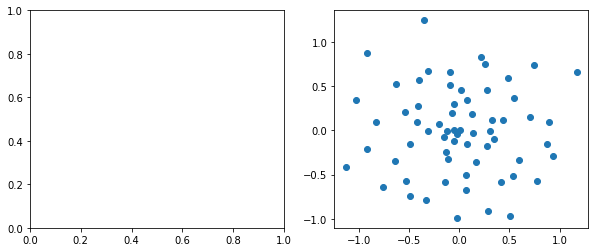

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


80
0.39346665


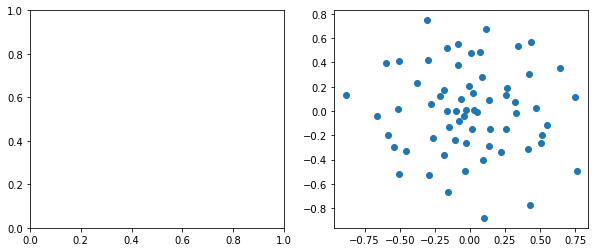

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
0.38095328


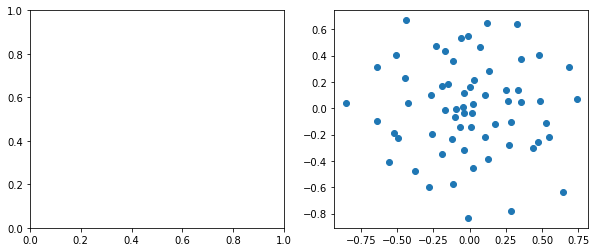

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


120
0.37689617


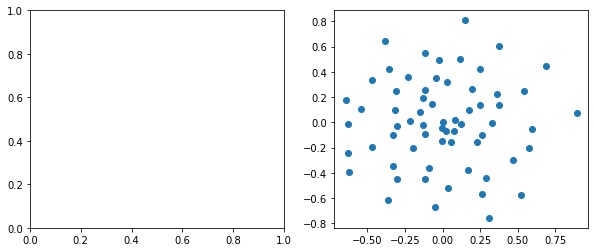

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


140
0.3251625


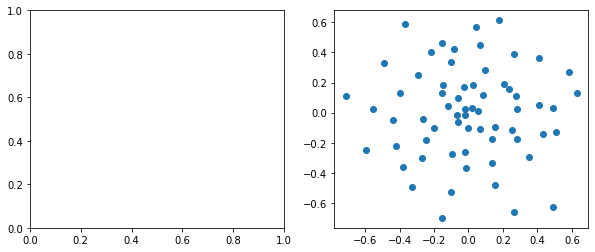

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


160
0.28774297


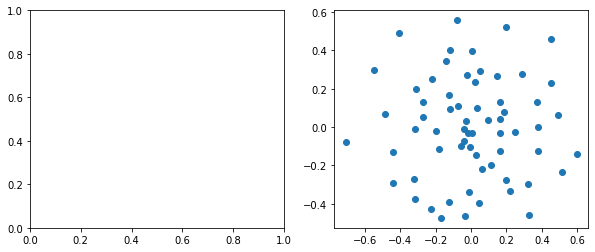

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:

# Full
folder = "./lightning_logs/version_60/checkpoints/"
stats_0d_v60, stats_1d_v60, norm_v60 = calculate_topo_stats(folder, model,mask_index )

0
1.3793666


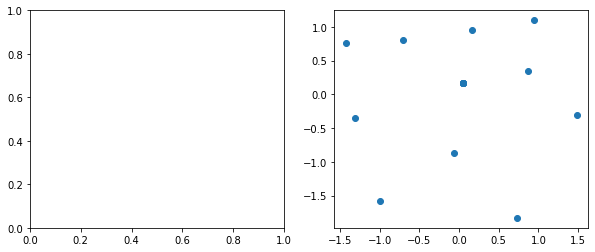

0
1.5575777


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


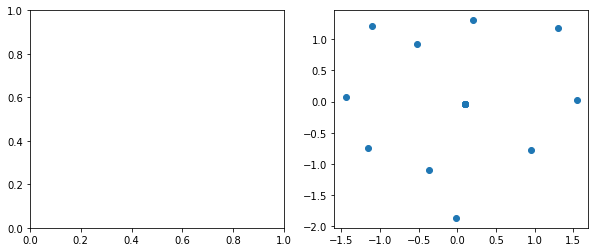

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.5263795


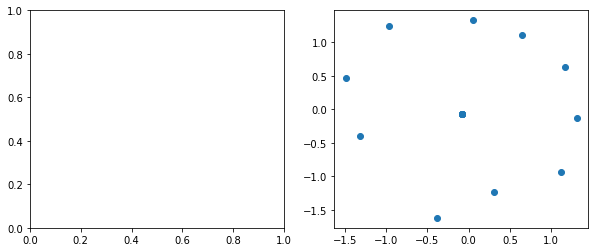

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.4652193


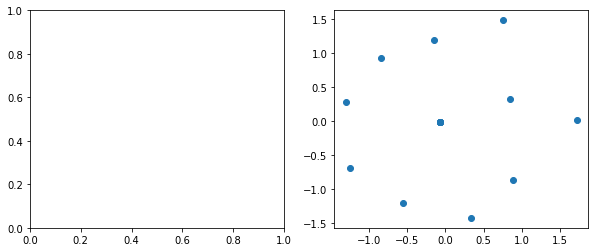

0
1.4377768


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


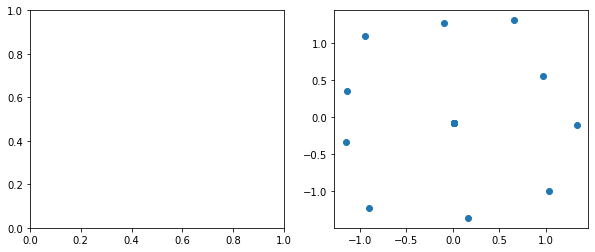

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.4467318


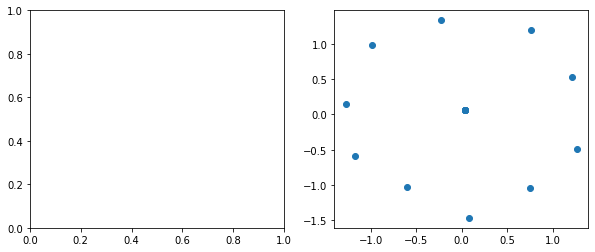

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.4279114


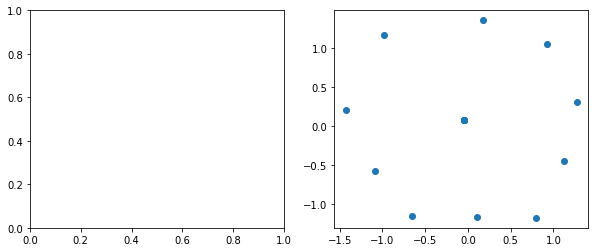

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.1262653


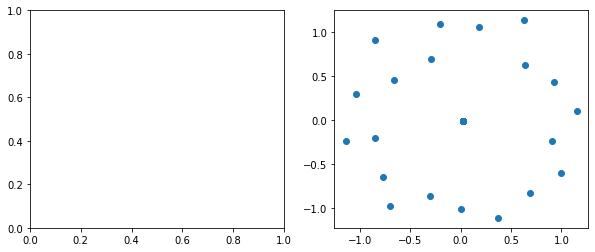

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.420992


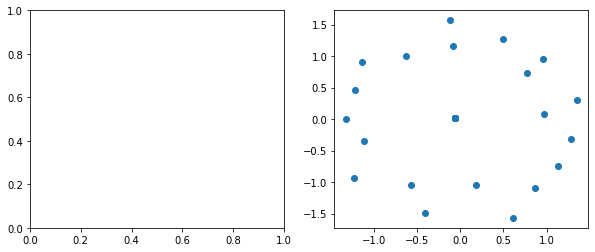

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.3760664


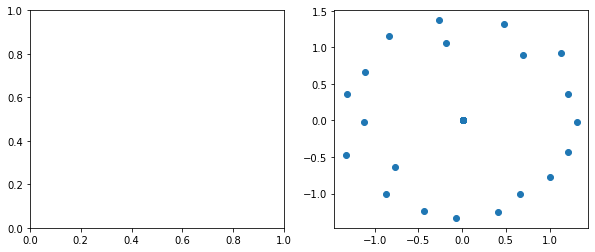

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.3539618


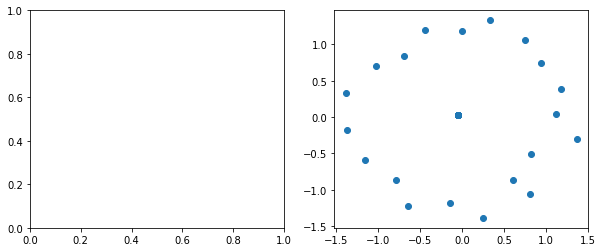

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.3625678


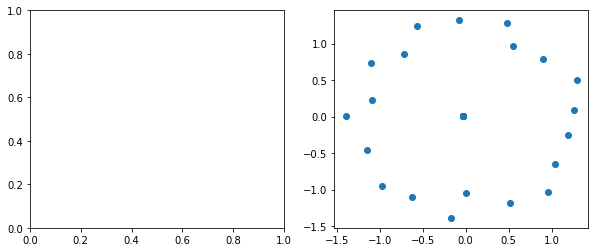

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.3435749


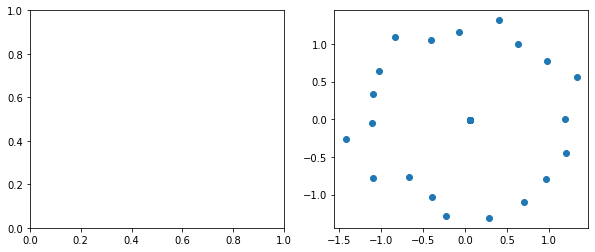

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.0542133


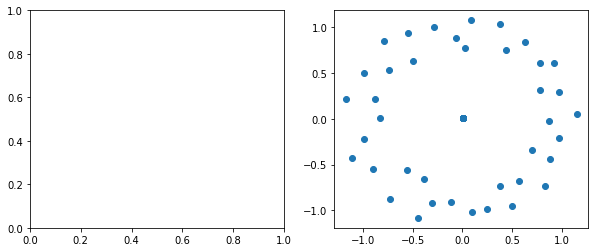

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.3717327


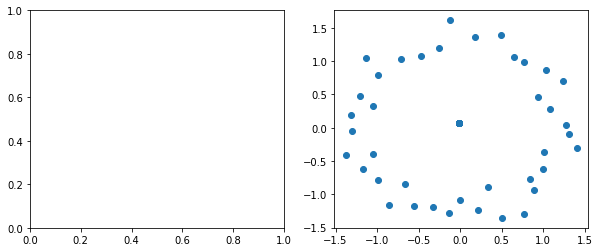

0
1.3633856


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


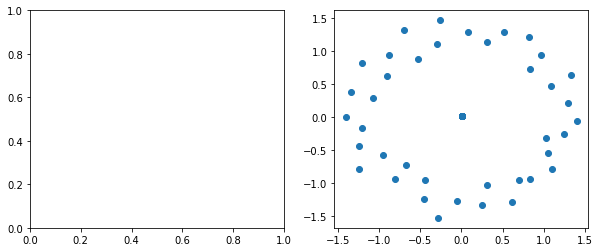

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.3135198


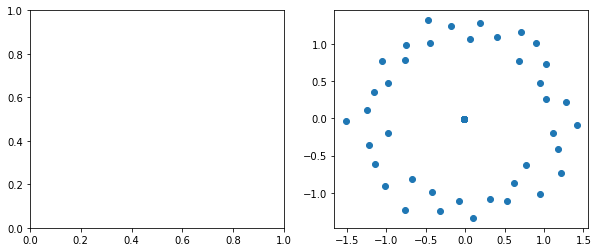

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.318049


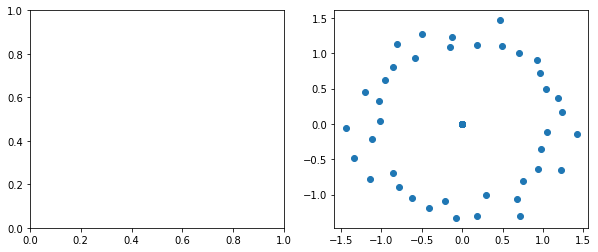

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1.2870082


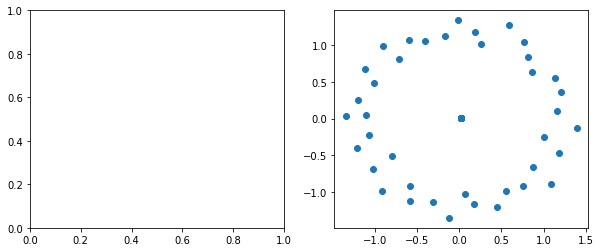

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Better
folder = "./lightning_logs/version_78/checkpoints/"
stats_0d_v78, stats_1d_v78, norm_v78 = calculate_topo_stats(folder, model,mask_index )


0
1.2843969


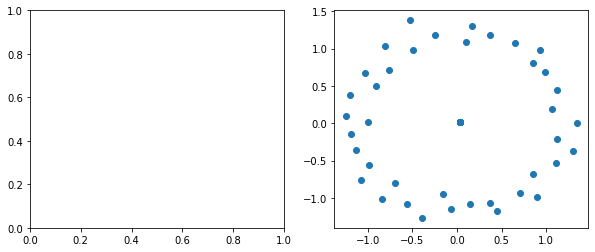

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20
0.7990618


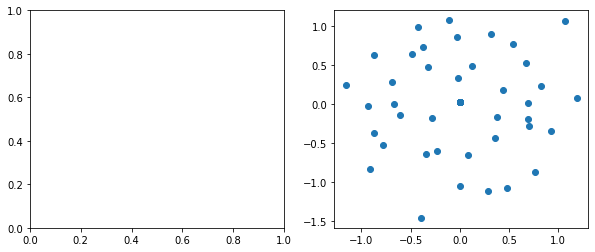

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40
0.81488025


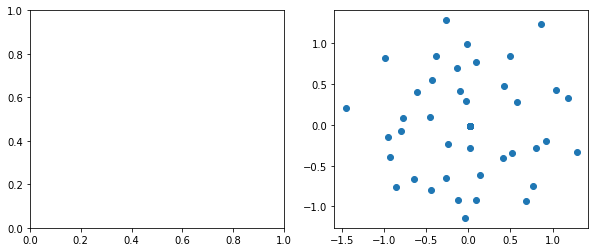

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


60
0.79334426


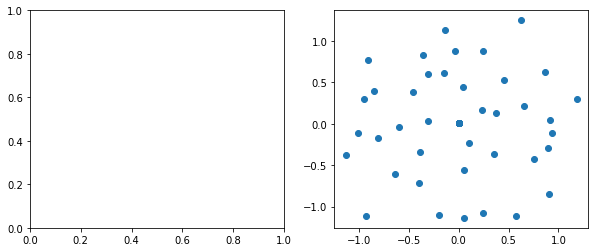

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


80
0.56958187


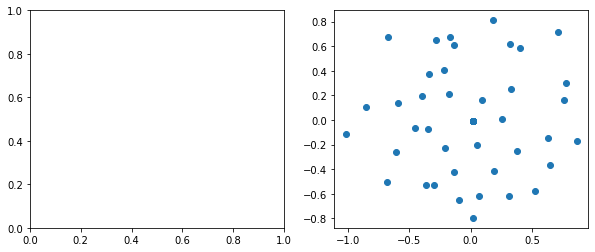

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
0.5565246


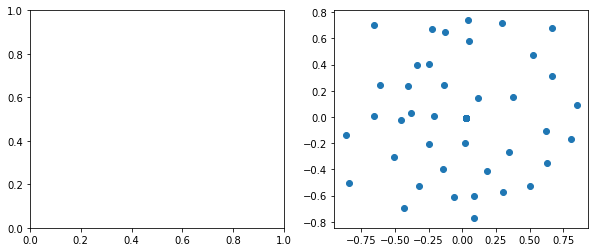

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


120
0.5495292


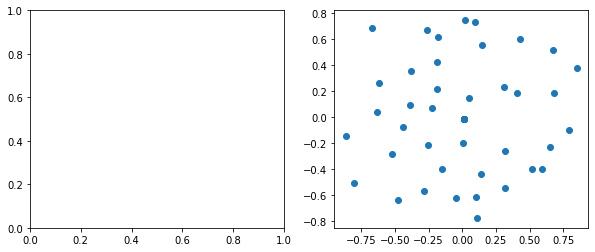

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


140
0.48050523


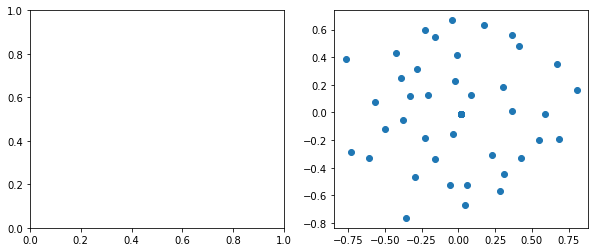

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


160
0.43558493


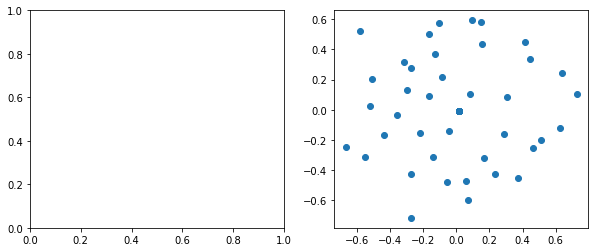

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# the worst
folder = "./lightning_logs/version_73/checkpoints/"
stats_0d_v73, stats_1d_v73, norm_v73 = calculate_topo_stats(folder, model,mask_index )

In [339]:
for key in mask_index:
    plt.plot(np.array(norm_v60[key]).T[2], color = "green", label="full")
    plt.plot(np.array(norm_v73[key]).T[2], color = "blue", label="step=0.2")
    plt.plot(np.array(norm_v78[key]).T[2], color = "red", label="step=0.1")
    plt.legend()
    plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 0

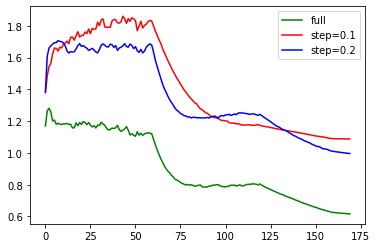

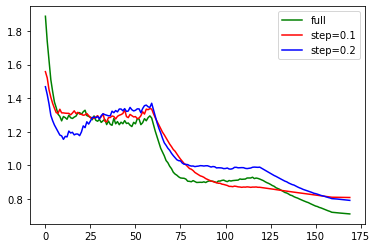

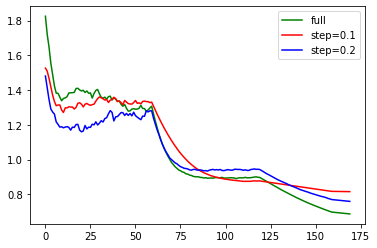

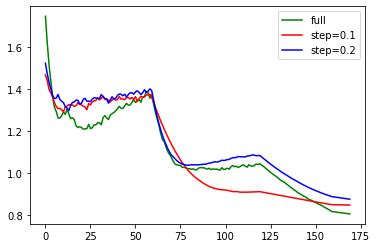

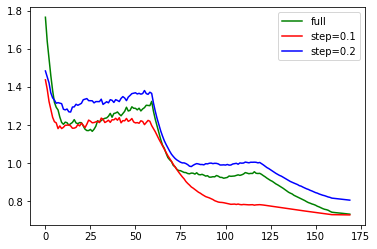

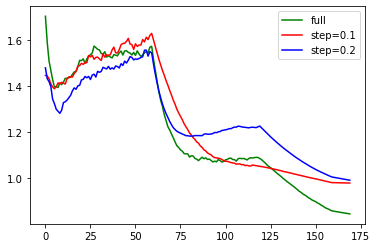

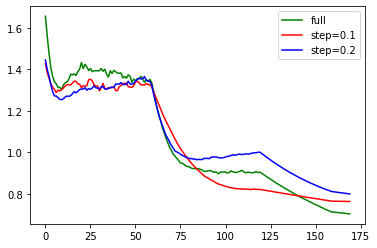

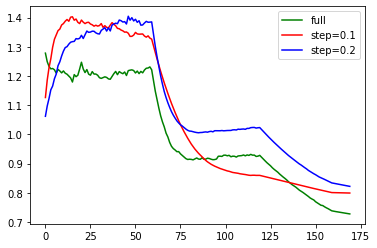

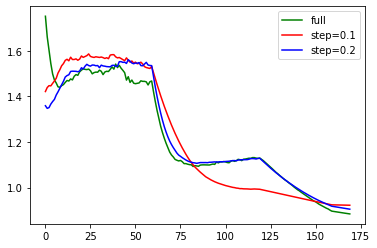

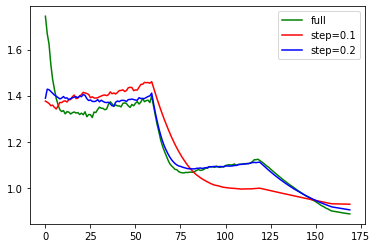

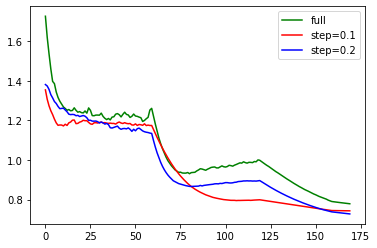

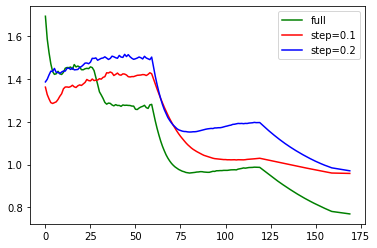

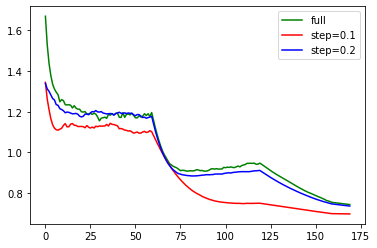

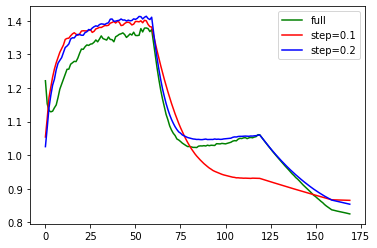

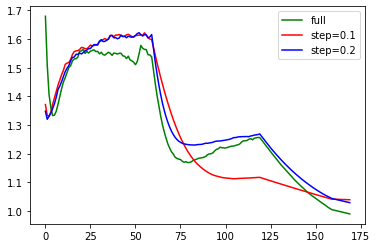

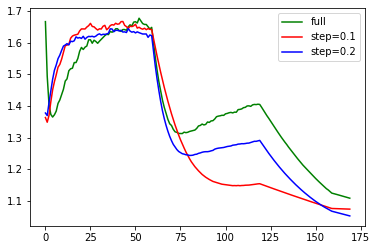

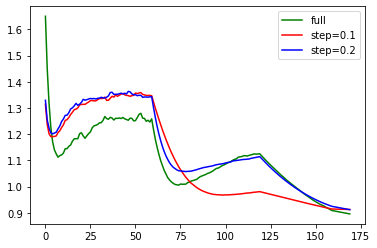

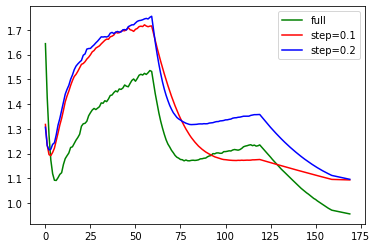

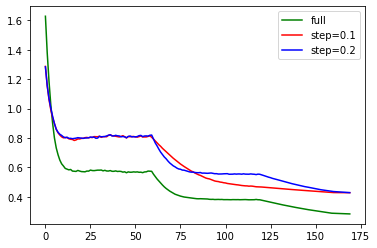

In [396]:
# len(deaths),np.sum(deaths),np.mean(deaths), np.min(deaths ), np.max(deaths )

for key in mask_index:#[-2:]:
    plt.plot(np.array(stats_0d_v60[key]).T[2], color = "green", label="full")
    plt.plot(np.array(stats_0d_v78[key]).T[2], color = "red", label="step=0.1")
    
    plt.plot(np.array(stats_0d_v73[key]).T[2], color = "blue", label="step=0.2")
    plt.legend()
    plt.show()

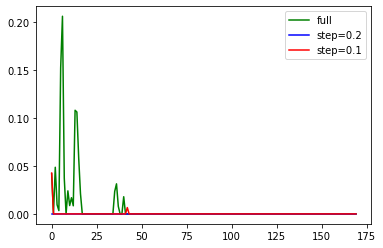

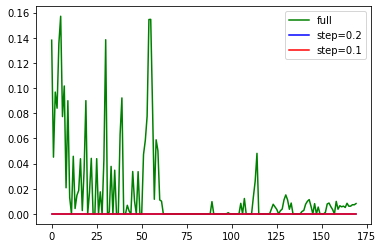

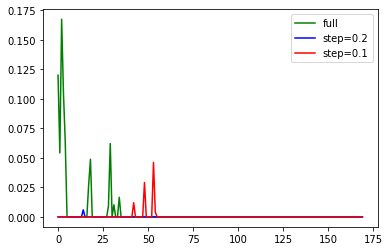

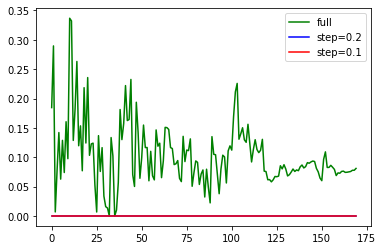

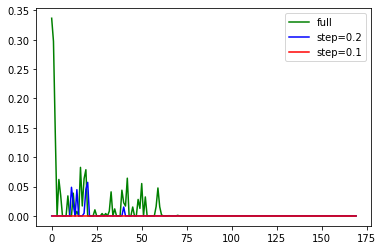

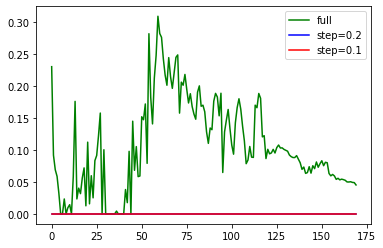

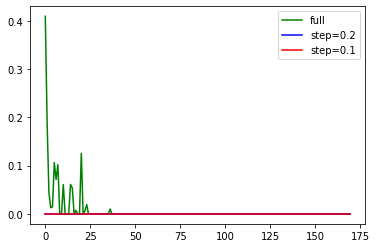

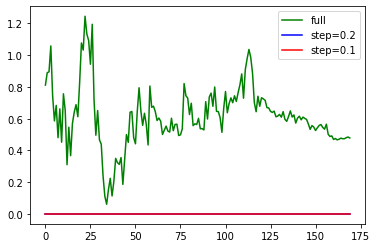

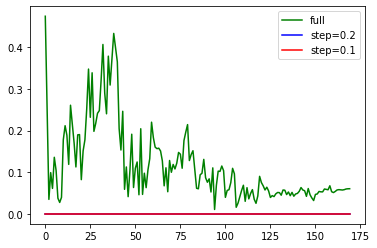

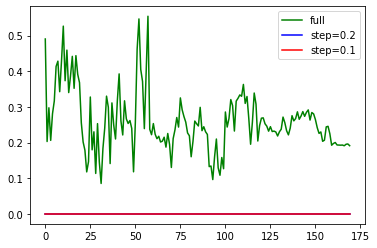

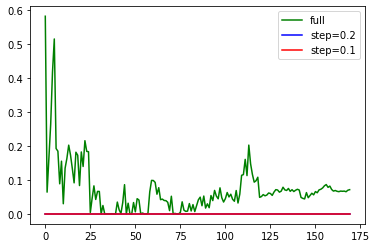

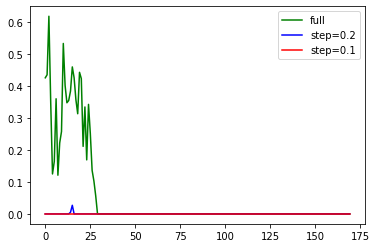

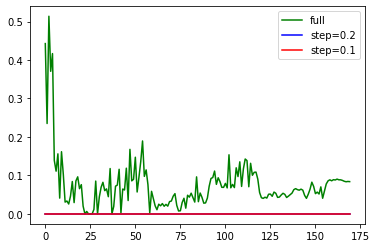

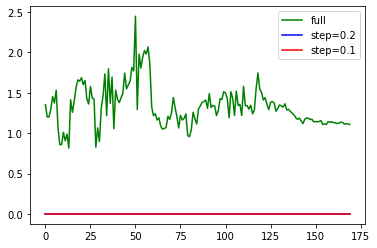

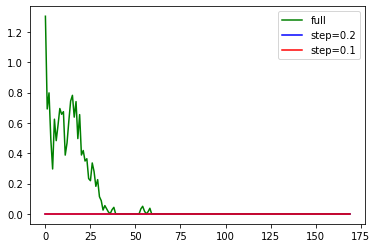

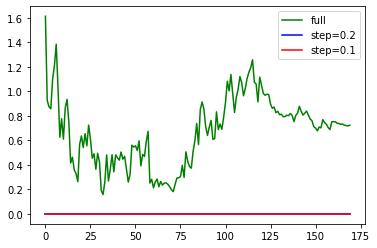

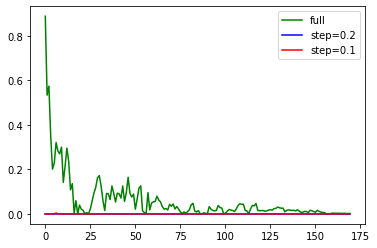

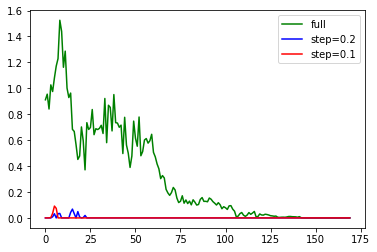

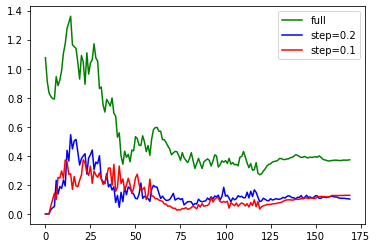

In [22]:

for key in mask_index:
    # total_persistence, n_1d_points, average_lifespan_1d
    plt.plot(np.array(stats_1d_v60[key]).T[0], color = "green", label="full")
    plt.plot(np.array(stats_1d_v73[key]).T[0], color = "blue", label="step=0.2")
    plt.plot(np.array(stats_1d_v78[key]).T[0], color = "red", label="step=0.1")
    plt.legend()
    plt.show()

In [21]:
for key in mask_index:
    print(np.array(stats_1d_v60[key]).T[0][1])

0.0
0.04510068893432617
0.05423569679260254
0.28960323333740234
0.29725074768066406
0.09193634986877441
0.19193851947784424
0.8895931243896484
0.25792717933654785
0.20290255546569824
0.06420552730560303
0.4352682828903198
0.2349228858947754
1.2004389762878418
0.6921664476394653
0.927519679069519
0.5332237482070923
0.9549813270568848
0.9138516187667847


In [18]:
for key in mask_index:
    print(np.array(stats_1d_v60[key]).T[0][5])

24.0

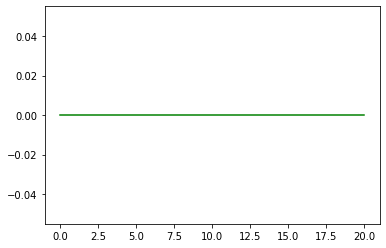

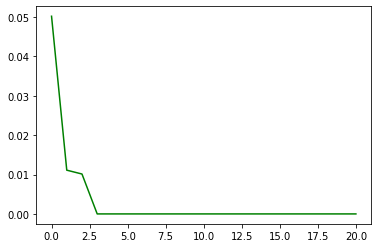

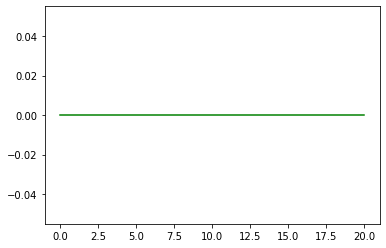

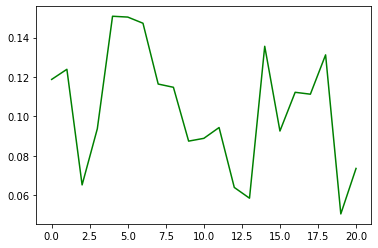

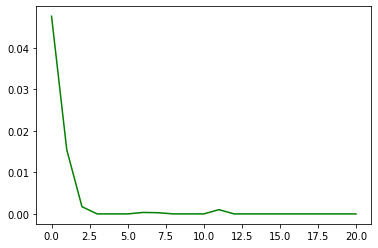

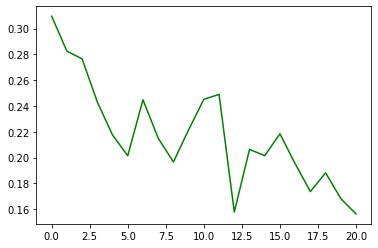

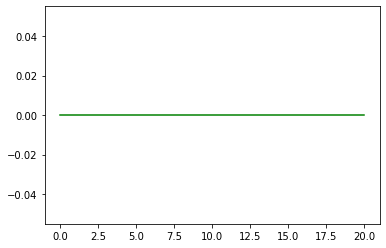

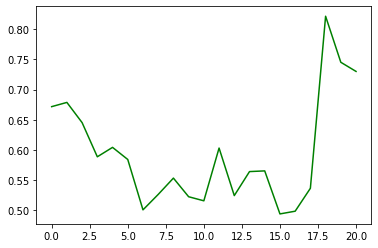

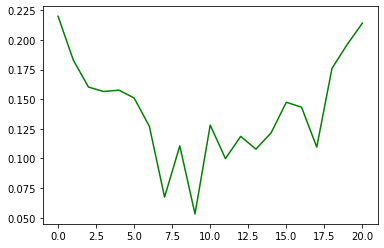

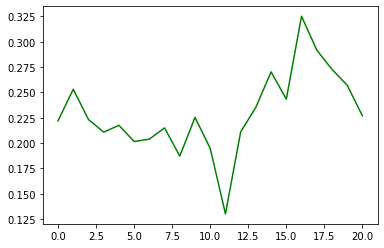

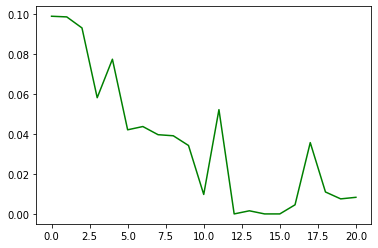

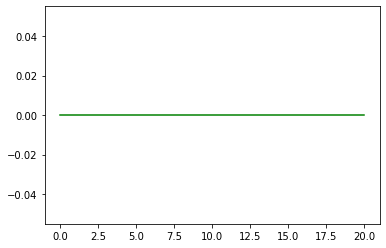

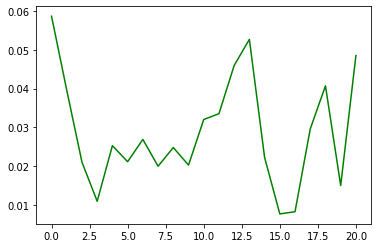

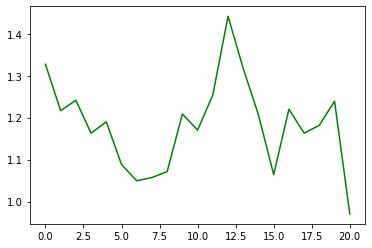

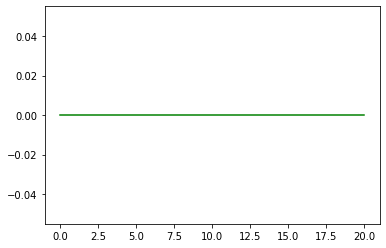

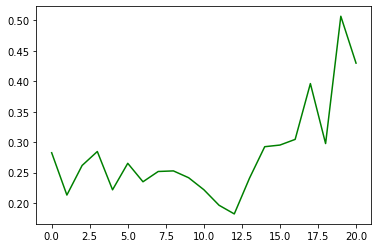

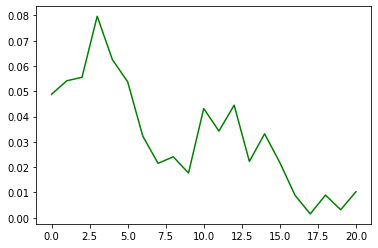

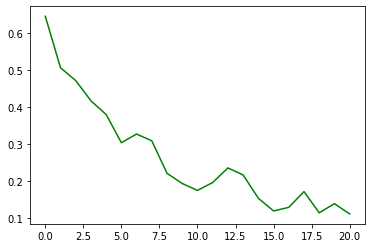

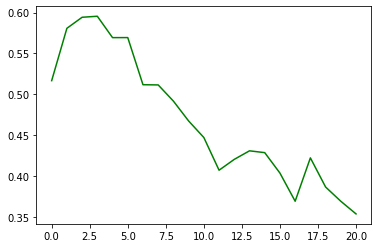

In [399]:
for key in mask_index:
    # total_persistence, n_1d_points, average_lifespan_1d
    plt.plot(np.array(stats_1d_v60[key]).T[0][59:80], color = "green", label="full")
    plt.show()

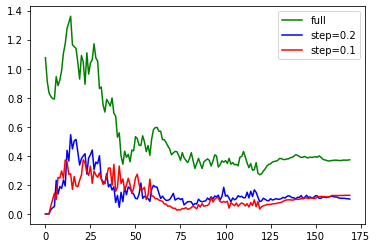

In [31]:

for key in mask_index[-1:]:
    # total_persistence, n_1d_points, average_lifespan_1d
    plt.plot(np.array(stats_1d_v60[key]).T[0], color = "green", label="full")
    plt.plot(np.array(stats_1d_v73[key]).T[0], color = "blue", label="step=0.2")
    plt.plot(np.array(stats_1d_v78[key]).T[0], color = "red", label="step=0.1")
    plt.legend()
    plt.show()

In [1]:
from os import listdir
from os.path import isfile, join
import math
import torch

from models.imagenet_resnet import resnet18, resnet50
from models.cifar_resnet import resnet20, resnet32, resnet56
from torch import nn as nn 

from scipy.spatial.distance import cdist
import numpy as np

import gudhi as gd
from gudhi import wasserstein

import time

from scipy.spatial import distance
import numpy as np
from ripser import ripser
from persim import plot_diagrams
from gph.python import ripser_parallel
from scipy.spatial.distance import pdist, squareform
#import ripserplusplus as rpp_py
import time
import matplotlib.pyplot as plt

from sklearn import manifold 

In [2]:
from pruning.pruning_geometric_mean_mine import Mask

In [3]:

folder = "./lightning_logs/version_60/checkpoints/"
onlyfiles = np.array([f for f in listdir(folder) if isfile(join(folder, f))])


epoch = 169

model = resnet20(num_classes =10)
mask_index = [x for x in range(0, 57, 3)]

norms = {key:[] for key in mask_index}
name = 'epoch='+str(epoch)+"-"
file_name = onlyfiles[[name in i for i in onlyfiles]][0]
file = torch.load(folder+file_name,
                 map_location=torch.device('cpu'))
ckpt_dict = {'.'.join(k.split(".")[1:]): v for k, v in file["state_dict"].items()}
model.load_state_dict(ckpt_dict)

mask_index = [x for x in range(0, 57, 3)]

for index, item in enumerate(model.parameters()):
    if index in mask_index:
        layer_weight = item
        weight_vec = layer_weight.view(layer_weight.size()[0], -1).data
        weight_torch = layer_weight.data
        norm = np.linalg.norm(weight_vec, axis=1)
        #non_empty_norm = norm[norm!=0]
        # print(layer_weight.shape)
        wass_dist = []
        similar_matrix = cdist(weight_vec, weight_vec, 'euclidean')
        
        topo_res = ripser_parallel(similar_matrix, metric="precomputed",
                       maxdim=1, n_threads=-1, return_generators=True)
        bd_pairs = topo_res['dgms']
        generators = topo_res['gens']


CifarResNet : Depth : 20 , Layers for each block : 3


In [4]:

folder = "./lightning_logs/version_60/checkpoints/"
onlyfiles = np.array([f for f in listdir(folder) if isfile(join(folder, f))])


epoch = 169

model = resnet20(num_classes =10)
mask_index = [x for x in range(0, 57, 3)]

norms = {key:[] for key in mask_index}
name = 'epoch='+str(epoch)+"-"
file_name = onlyfiles[[name in i for i in onlyfiles]][0]
file = torch.load(folder+file_name,
                 map_location=torch.device('cpu'))
ckpt_dict = {'.'.join(k.split(".")[1:]): v for k, v in file["state_dict"].items()}
model.load_state_dict(ckpt_dict)

mask_index = [x for x in range(0, 57, 3)]

CifarResNet : Depth : 20 , Layers for each block : 3


In [5]:
model = model.cuda()

mask = Mask()

mask.init_length(model, 0.4)
mask.init_mask(None, model)
model = mask.do_similar_mask(model)
model = mask.do_reinit(model)
mask.if_zero(model)

RuntimeError: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

/tmp/ipykernel_238917/1940160718.py:37: RuntimeWarning: invalid value encountered in double_scalars
  average_lifespan_1d = total_persistence/n_1d_points


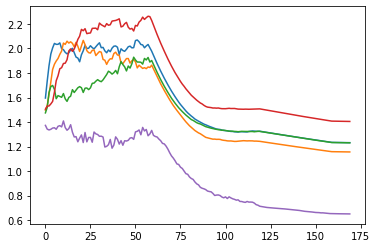

In [52]:
# total_persistence, n_1d_points, average_lifespan_1d
for i in mask_index[-5:]:
    plt.plot(np.array(stats_0d[i]).T[4])


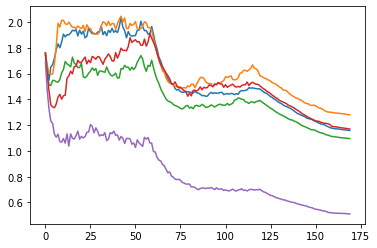

In [45]:
# total_persistence, n_1d_points, average_lifespan_1d
for i in mask_index[-5:]:
    plt.plot(np.array(stats_0d[i]).T[4])


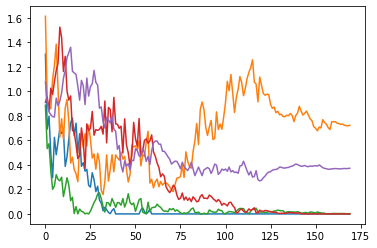

In [44]:
# total_persistence, n_1d_points, average_lifespan_1d
for i in mask_index[-5:]:
    plt.plot(np.array(stats_1d[i]).T[0])


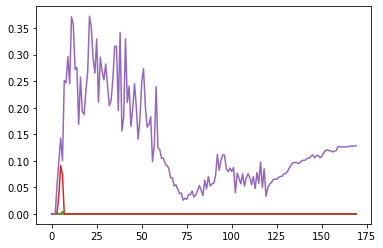

In [53]:
# total_persistence, n_1d_points, average_lifespan_1d
for i in mask_index[-5:]:
    plt.plot(np.array(stats_1d[i]).T[0])


In [68]:
mask_index, len(mask_index)

([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54], 19)

In [15]:
#model = resnet20(num_classes=10)
mask_index = [x for x in range(0, 57, 3)]
for index, item in enumerate(model.parameters()):
    if index in mask_index:
        layer_weight = item
weight_vec = layer_weight.view(layer_weight.size()[0], -1).data
weight_torch = layer_weight.data
similar_matrix = cdist(weight_vec, weight_vec, 'euclidean')

In [16]:
topo_res = ripser_parallel(similar_matrix, metric="precomputed",
                           maxdim=1, n_threads=-1, return_generators=True)


bd_pairs = topo_res['dgms']
generators = topo_res['gens']

array([0.17751294, 0.186709  , 0.22300646, 0.23418665, 0.2615638 ,
       0.29216322, 0.30039272, 0.31190124, 0.31231934, 0.31645226,
       0.32764193, 0.32806778, 0.33186048, 0.3330064 , 0.33735612,
       0.3545091 , 0.35811767, 0.3704388 , 0.3762915 , 0.38564688,
       0.38917443, 0.4000591 , 0.40720493, 0.42231455, 0.42372796,
       0.4252554 , 0.4345995 , 0.43991008, 0.44023687, 0.44387522,
       0.44562316, 0.45733985, 0.4608349 , 0.47165778, 0.4747376 ,
       0.48000407, 0.48073328, 0.48490033, 0.48640966, 0.48842385,
       0.49295807, 0.4943255 , 0.5002048 , 0.5476044 , 0.55616564,
       0.5854691 , 0.5948947 , 0.59701824, 0.5971978 , 0.6070031 ,
       0.62077314, 0.6340721 , 0.6568554 , 0.6647968 , 0.6742092 ,
       0.6876401 , 0.74296343, 0.744758  , 0.7944059 , 0.7966341 ,
       0.836584  , 0.83714   , 0.8946743 ], dtype=float32)

In [38]:
stats_0d, stats_1d = [], []

In [40]:
# 0-dim stats
deaths = bd_pairs[0].T[1][:-1]
print(len(deaths),np.sum(deaths),np.mean(deaths), np.min(deaths ), np.max(deaths ))
stats_0d.append([len(deaths),np.sum(deaths),np.mean(deaths), np.min(deaths ), np.max(deaths )])
# 1st dim stats
total_persistence = wasserstein.wasserstein_distance(bd_pairs[1], np.array([[0, 0]]), 
                                 order=1, internal_p=1)
n_1d_points = len(bd_pairs[1])
average_lifespan_1d = total_persistence/n_1d_points
previous_bd = bd_pairs[1]
dist_to_prev = wasserstein.wasserstein_distance(bd_pairs[1], previous_bd, 
                                 order=1, internal_p=1)
stats_1d.append([total_persistence, n_1d_points, average_lifespan_1d, dist_to_prev])
print(total_persistence, n_1d_points, average_lifespan_1d, dist_to_prev)

63 30.234514 0.47991294 0.17751294 0.8946743
0.5116546154022217 17 0.030097330317777747 0.0


In [41]:
stats_0d

[[63, 30.234514, 0.47991294, 0.17751294, 0.8946743],
 [63, 30.234514, 0.47991294, 0.17751294, 0.8946743]]

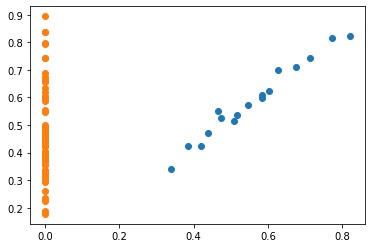

In [8]:
plt.scatter(bd_pairs[1].T[0],bd_pairs[1].T[1])

plt.scatter(bd_pairs[0].T[0],bd_pairs[0].T[1])
plt.show()
#plt.plot([1.8, 2.2], [1.8, 2.2])

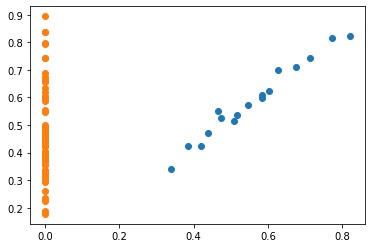

In [9]:
plt.scatter(bd_pairs[1].T[0],bd_pairs[1].T[1])
plt.scatter(bd_pairs[0].T[0],bd_pairs[0].T[1])
plt.show()
#plt.plot([1.8, 2.2], [1.8, 2.2])

In [10]:
mds_model = manifold.MDS(n_components = 2, random_state = 124,
    dissimilarity = 'precomputed')
mds_fit = mds_model.fit(similar_matrix)
mds_coords = mds_model.fit_transform(similar_matrix) 

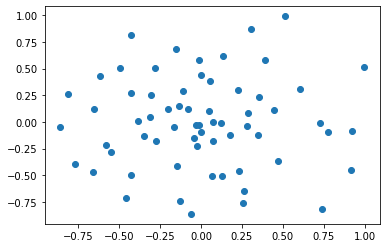

In [11]:
plt.scatter(mds_coords[:,0],mds_coords[:,1])

In [12]:
bd_pairs[1].T

array([[0.82032937, 0.7737643 , 0.7139445 , 0.6747189 , 0.62689847,
        0.60334635, 0.584822  , 0.5845902 , 0.5468206 , 0.5164548 ,
        0.5093748 , 0.4724304 , 0.46418542, 0.43819296, 0.41892266,
        0.38444734, 0.3391104 ],
       [0.82306045, 0.81575274, 0.7439895 , 0.71121   , 0.6987576 ,
        0.6252153 , 0.5998105 , 0.6099325 , 0.5731638 , 0.53787494,
        0.5154678 , 0.5256686 , 0.5499266 , 0.4699288 , 0.42233053,
        0.42233053, 0.3395879 ]], dtype=float32)